In [36]:
import os
import glob
import numpy as np
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure
from PIL import Image
import zipfile
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [60]:
import os
import pandas as pd
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from skimage import measure
from PIL import Image

class DICOMPreprocessing:
    def __init__(self, patient_df):
        self.patient_df = patient_df
        self.ct_df = patient_df[patient_df['Modality'] == 'CT']
        self.seg_df = patient_df[patient_df['Modality'] == 'SEG']
        
        # Create dictionaries to map SOP Instance UID to their file paths
        self.ct_dict = dict(zip(self.ct_df['SOPInstanceUID'], self.ct_df['image_path']))
        self.seg_dict = dict(zip(self.seg_df['SOPInstanceUID'], self.seg_df['image_path']))

    @staticmethod
    def load_and_prepare_data():
        """Load and prepare data from CSV files."""
        df_label = pd.read_csv("/kaggle/input/nsclc-radiogenomics-6-1-21-version-4/processed_df.csv")
        meta_data = pd.read_csv("/kaggle/input/nsclc-radiogenomics-6-1-21-version-4/metadata.csv")

        # Perform a left join to keep all rows from df_label
        df = pd.merge(df_label, meta_data, left_on='SeriesInstanceUID', right_on='Series UID', how='left')

        # Filter and create patient dictionary
        list_StudyInstanceUID = list(df[df['Modality'] == 'SEG']['StudyInstanceUID'])
        filtered_df = df[df['StudyInstanceUID'].isin(list_StudyInstanceUID)]

        patient_dict = {patient_id: filtered_df[filtered_df['Patient ID'] == patient_id] for patient_id in df['Patient ID'].unique()}
        key_list = list(set(filtered_df['Patient ID']))

        patient_variables = {f'patient_{n}': patient_dict[key] for n, key in enumerate(key_list)}
        list_key = list(set(patient_variables.keys()))

        return patient_variables, list_key
    
    @staticmethod
    def save_data(file_name):
        """Load and prepare data from CSV files, then save the merged DataFrame to a CSV file."""
        df_label = pd.read_csv("/kaggle/input/nsclc-radiogenomics-6-1-21-version-4/processed_df.csv")
        meta_data = pd.read_csv("/kaggle/input/nsclc-radiogenomics-6-1-21-version-4/metadata.csv")

        # Perform a left join to keep all rows from df_label
        df = pd.merge(df_label, meta_data, left_on='SeriesInstanceUID', right_on='Series UID', how='left')

        # Save the DataFrame to a CSV file
        df.to_csv(file_name, index=False)  # Ensure index is not saved to the file

        print(f"Data saved to {file_name}")
    
    def _get_tumor_bounding_box(self, seg_slice):
        """Compute the bounding box for the segmented tumor area."""
        tumor_pixels = np.argwhere(seg_slice > 0)
        if tumor_pixels.size == 0:
            return (0, 0, seg_slice.shape[1], seg_slice.shape[0])
        
        min_y, min_x = tumor_pixels.min(axis=0)
        max_y, max_x = tumor_pixels.max(axis=0)
        
        return (min_x, min_y, max_x + 1, max_y + 1)

    def visualize_largest_mask(self):
        """Visualize the largest mask found in the segmentations."""
        largest_mask_uid, largest_ct_pixel_array, largest_seg_slice = self._find_largest_mask()
        if not largest_mask_uid:
            print("No largest mask found.")
            return

        print(f"Visualizing largest mask with UID: {largest_mask_uid}")

        # Plot the tumor area
        plt.figure(figsize=(18, 6))
        plt.suptitle(f"Patient ID: {largest_mask_uid}", fontsize=16)

        # Plot original CT image
        plt.subplot(1, 3, 1)
        plt.imshow(largest_ct_pixel_array, cmap='gray')
        plt.title("CT Slice")
        plt.axis('off')

        # Plot CT image with segmentation overlay
        plt.subplot(1, 3, 2)
        plt.imshow(largest_ct_pixel_array, cmap='gray')

        highlighted_seg = np.zeros_like(largest_seg_slice)
        highlighted_seg[largest_seg_slice > 0] = 1

        contours = measure.find_contours(highlighted_seg, level=0.5)
        for contour in contours:
            plt.plot(contour[:, 1], contour[:, 0], color='red', linewidth=2)

        plt.imshow(largest_seg_slice, cmap='jet', alpha=0.3)
        plt.title("CT with SEG Overlay")
        plt.axis('off')

        # Plot full-screen tumor area
        plt.subplot(1, 3, 3)
        tumor_bbox = self._get_tumor_bounding_box(largest_seg_slice)
        min_x, min_y, max_x, max_y = tumor_bbox

        # Create a zoomed-in view of the tumor area
        zoomed_tumor = largest_ct_pixel_array[min_y:max_y, min_x:max_x]

        plt.imshow(zoomed_tumor, cmap='gray')
        plt.title("Zoomed Tumor Area")
        plt.axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for suptitle
        
        plt.show()

    def _save_image(self, image_array, file_path):
        """Save the image array to a file as TIFF."""
        image_array = np.uint8(image_array)  # Convert to 8-bit
        image = Image.fromarray(image_array)
        image.save(file_path, format='TIFF')

    def save_largest_tumor_area(self, output_dir, image_size=(224, 224)):
        """Find the largest tumor area, resize it, and save it as a TIFF image."""
        largest_mask_uid, largest_ct_pixel_array, largest_seg_slice = self._find_largest_mask()

        if not largest_mask_uid:
            print("No largest mask found.")
            return

        # Calculate the bounding box
        tumor_bbox = self._get_tumor_bounding_box(largest_seg_slice)
        min_x, min_y, max_x, max_y = tumor_bbox

        # Zoom into the tumor area
        zoomed_tumor = largest_ct_pixel_array[min_y:max_y, min_x:max_x]

        # Normalize to 0-255 range for saving as TIFF
        zoomed_tumor_normalized = 255 * (zoomed_tumor - np.min(zoomed_tumor)) / (np.max(zoomed_tumor) - np.min(zoomed_tumor))
        zoomed_tumor_normalized = np.uint8(zoomed_tumor_normalized)

        # Create a PIL Image object
        image = Image.fromarray(zoomed_tumor_normalized)

        # Resize the image
        image = image.resize(image_size, Image.BICUBIC)

        # Save the image as TIFF
        file_name = f"{largest_mask_uid}.tiff"
        file_path = os.path.join(output_dir, file_name)
        image.save(file_path, format='TIFF')
        print(f"Saved tumor area image to {file_path}")

    def _find_largest_mask(self):
        """Find the largest mask area in the segmentations."""
        largest_area = 0
        largest_mask_uid = None
        largest_seg_slice = None
        largest_ct_pixel_array = None

        for _, seg_row in self.seg_df.iterrows():
            seg_uid = seg_row['SOPInstanceUID']
            seg_image_path = self.seg_dict.get(seg_uid)
            if not seg_image_path:
                print(f"SEG image path for UID {seg_uid} not found.")
                continue

            seg_ds = pydicom.dcmread(seg_image_path)
            referenced_series_sequence = seg_ds.get('ReferencedSeriesSequence', [])
            if not referenced_series_sequence:
                print(f"No Referenced Series Sequence found for SEG UID {seg_uid}.")
                continue

            for series_item in referenced_series_sequence:
                referenced_instance_sequence = series_item.get('ReferencedInstanceSequence', [])
                if not referenced_instance_sequence:
                    print(f"No Referenced Instance Sequence found for SEG Series Item in SEG UID {seg_uid}.")
                    continue

                for idx, instance_item in enumerate(referenced_instance_sequence):
                    ct_sop_instance_uid = instance_item.get('ReferencedSOPInstanceUID', 'N/A')
                    ct_image_path = self.ct_dict.get(ct_sop_instance_uid)
                    if not ct_image_path:
                        print(f"CT image for SOPInstanceUID {ct_sop_instance_uid} not found.")
                        continue

                    ct_ds = pydicom.dcmread(ct_image_path)
                    ct_pixel_array = ct_ds.pixel_array
                    seg_slice = seg_ds.pixel_array[idx, :, :]

                    # Calculate mask area
                    mask_area = np.sum(seg_slice > 0)
                    if mask_area > largest_area:
                        largest_area = mask_area
                        largest_mask_uid = seg_uid
                        largest_seg_slice = seg_slice
                        largest_ct_pixel_array = ct_pixel_array

        return largest_mask_uid, largest_ct_pixel_array, largest_seg_slice

    def visualize_all(self):
        """Visualize the largest masks for all patients."""
        for patient_key in self.patient_df['Patient ID'].unique():
            patient_data = self.patient_df[self.patient_df['Patient ID'] == patient_key]
            dicom_preprocessor = DICOMPreprocessing(patient_df=patient_data)
            
            print(f"Visualizing patient {patient_key}")
            dicom_preprocessor.visualize_largest_mask()

    def save_all(self, output_dir, image_size=(224, 224)):
        """Find the largest tumor areas for all patients, resize them to a specified size, and save them."""
        for patient_key in self.patient_df['Patient ID'].unique():
            patient_data = self.patient_df[self.patient_df['Patient ID'] == patient_key]
            dicom_preprocessor = DICOMPreprocessing(patient_df=patient_data)
            
            print(f"Saving tumor areas for patient {patient_key}")
            dicom_preprocessor.save_largest_tumor_area(output_dir=output_dir, image_size=image_size)

/tmp/ipykernel_36/2528614707.py:22: DtypeWarning: Columns (5,9,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df_label = pd.read_csv("/kaggle/input/nsclc-radiogenomics-6-1-21-version-4/processed_df.csv")


Visualizing patient patient_20
Visualizing largest mask with UID: 1.3.6.1.4.1.14519.5.2.1.4334.1501.203381030227108257540751328879


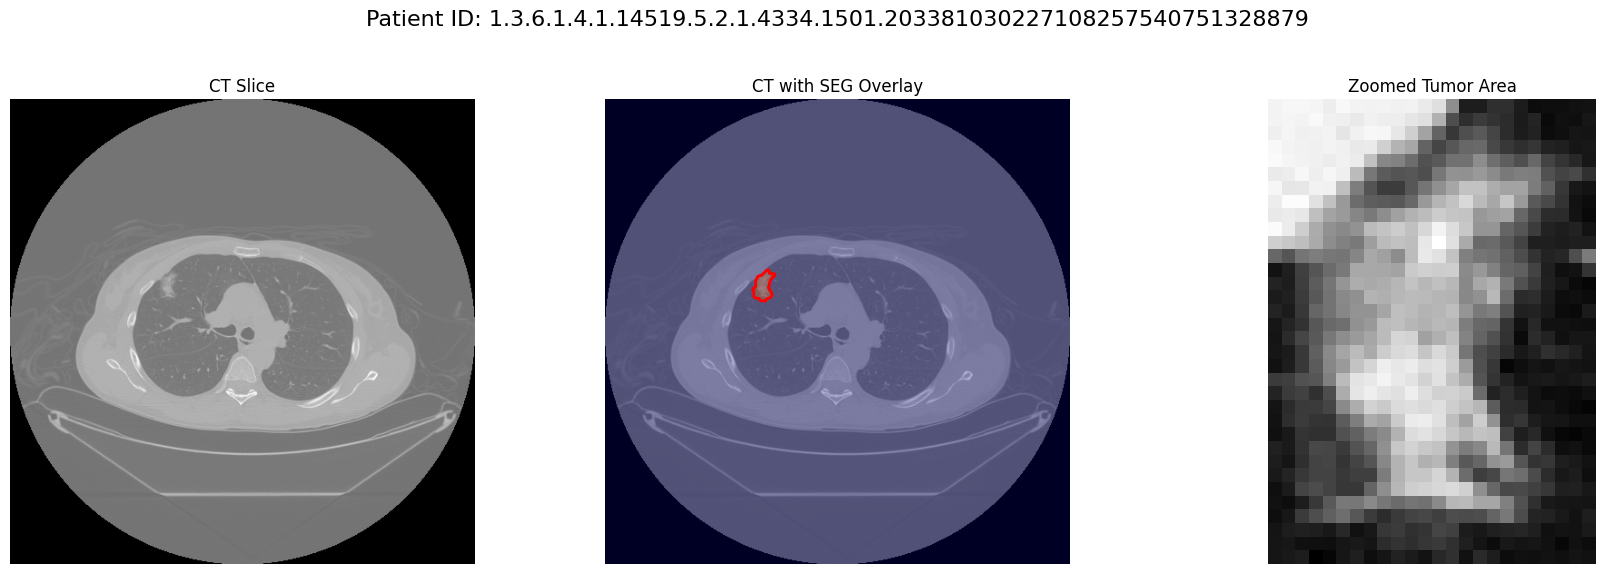

Visualizing patient patient_14
Visualizing largest mask with UID: 1.3.6.1.4.1.14519.5.2.1.4334.1501.303100348519968498568530525363


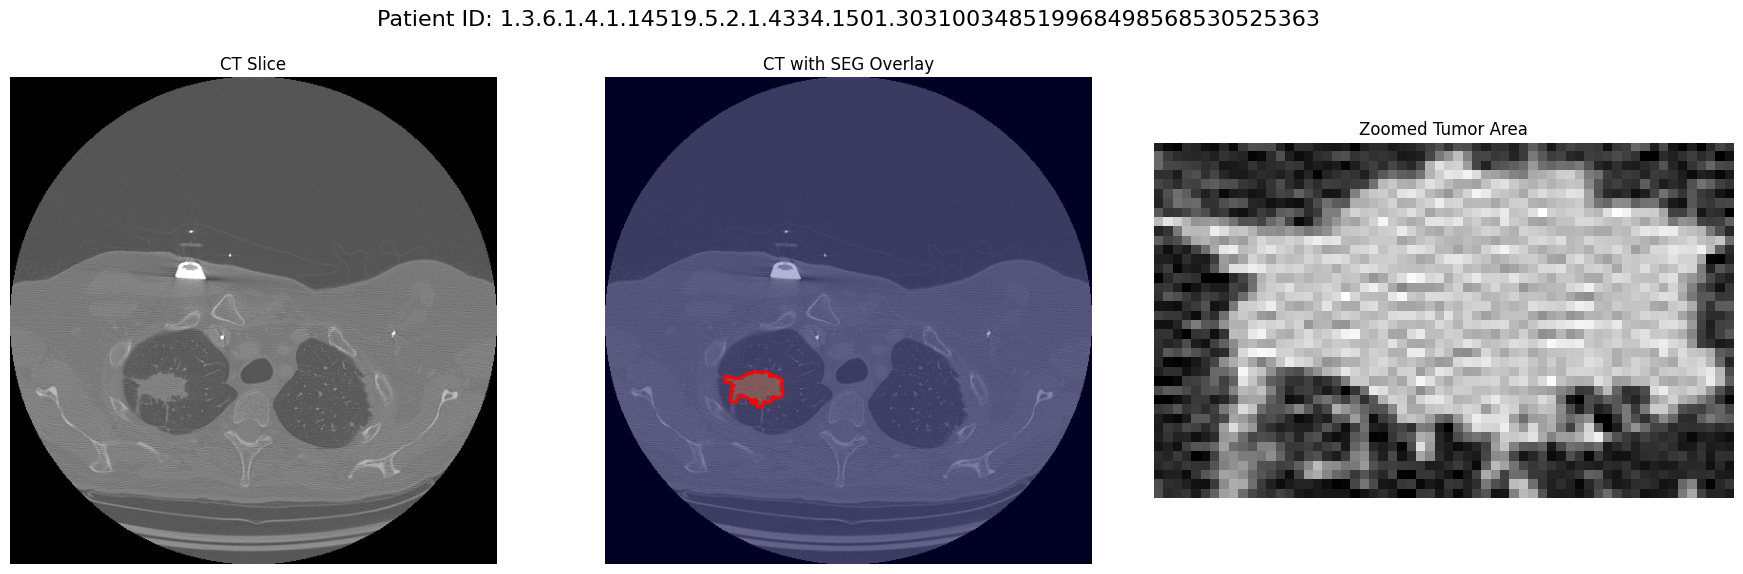

Visualizing patient patient_31
Visualizing largest mask with UID: 1.3.6.1.4.1.14519.5.2.1.4334.1501.553019895956157318420118637376


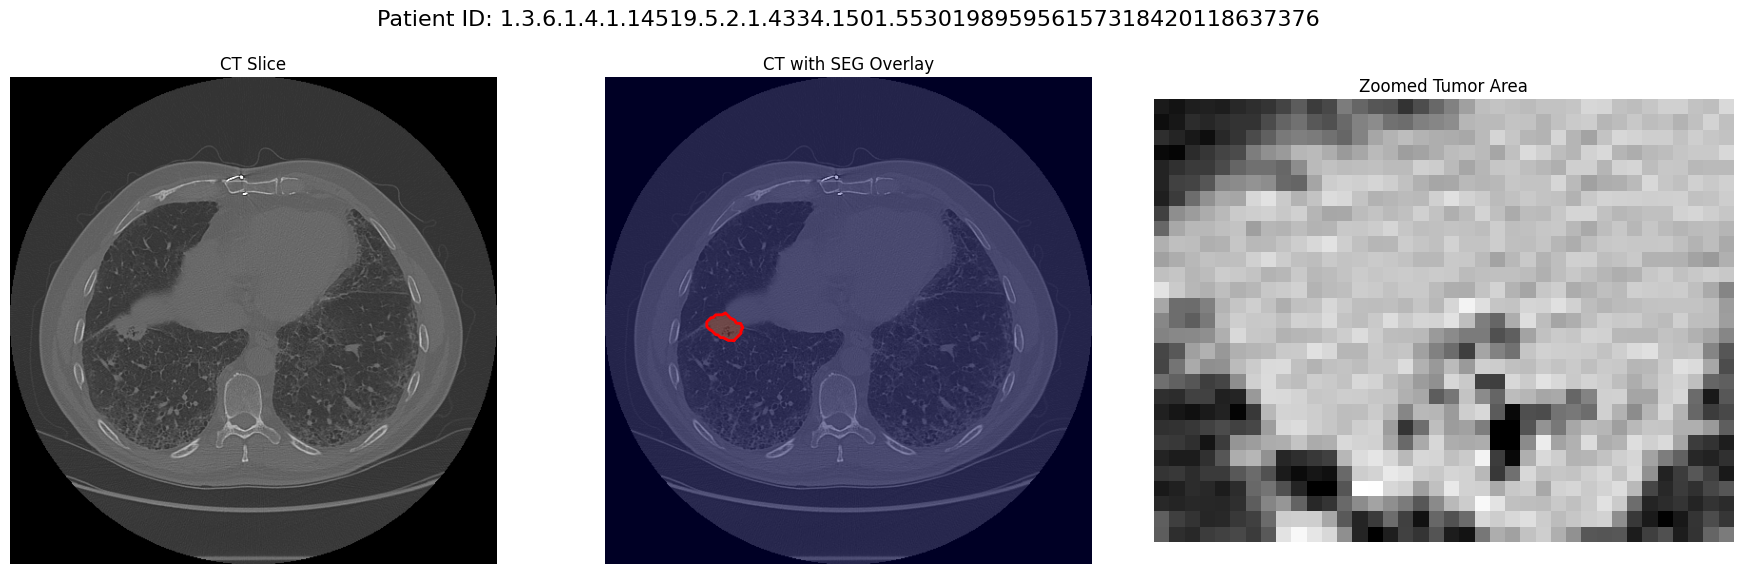

Visualizing patient patient_136
Visualizing largest mask with UID: 1.3.6.1.4.1.14519.5.2.1.4334.1501.299234974044277500539088418389


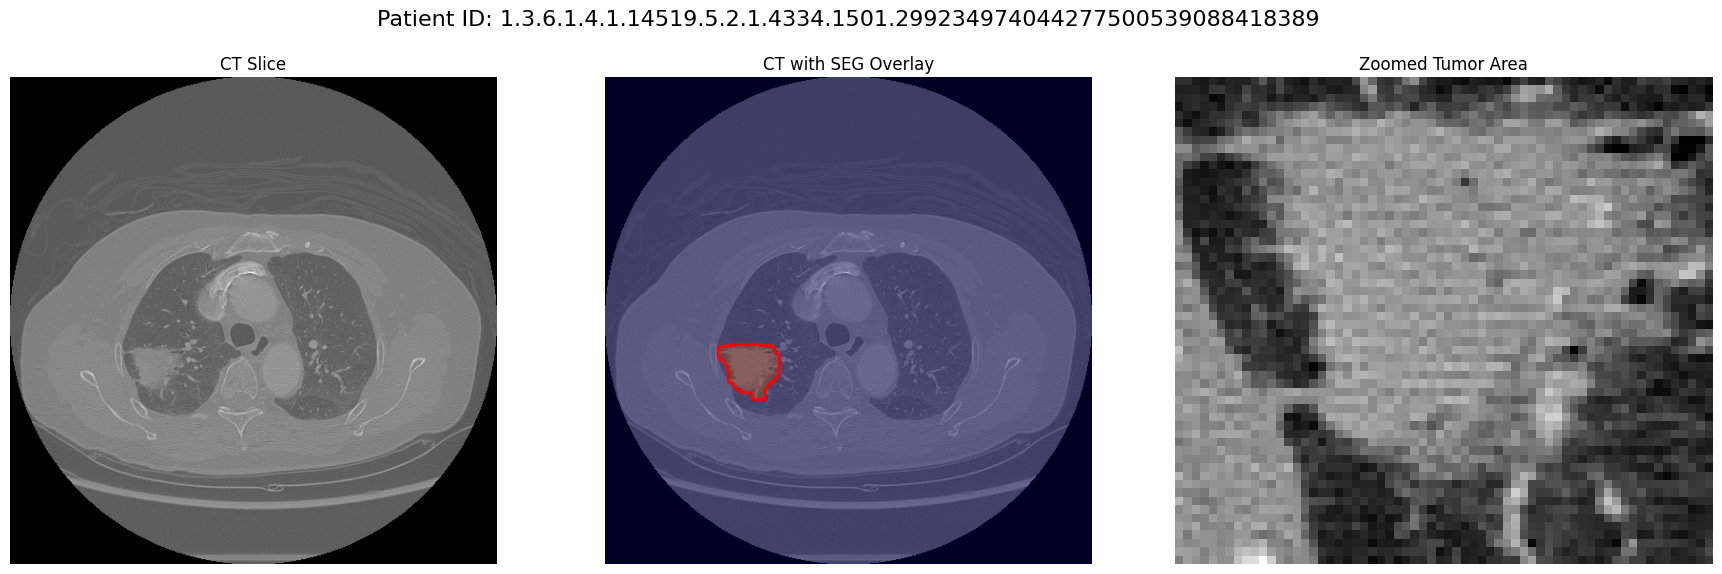

Visualizing patient patient_53
Visualizing largest mask with UID: 1.3.6.1.4.1.14519.5.2.1.4334.1501.311523950381527527192286090387


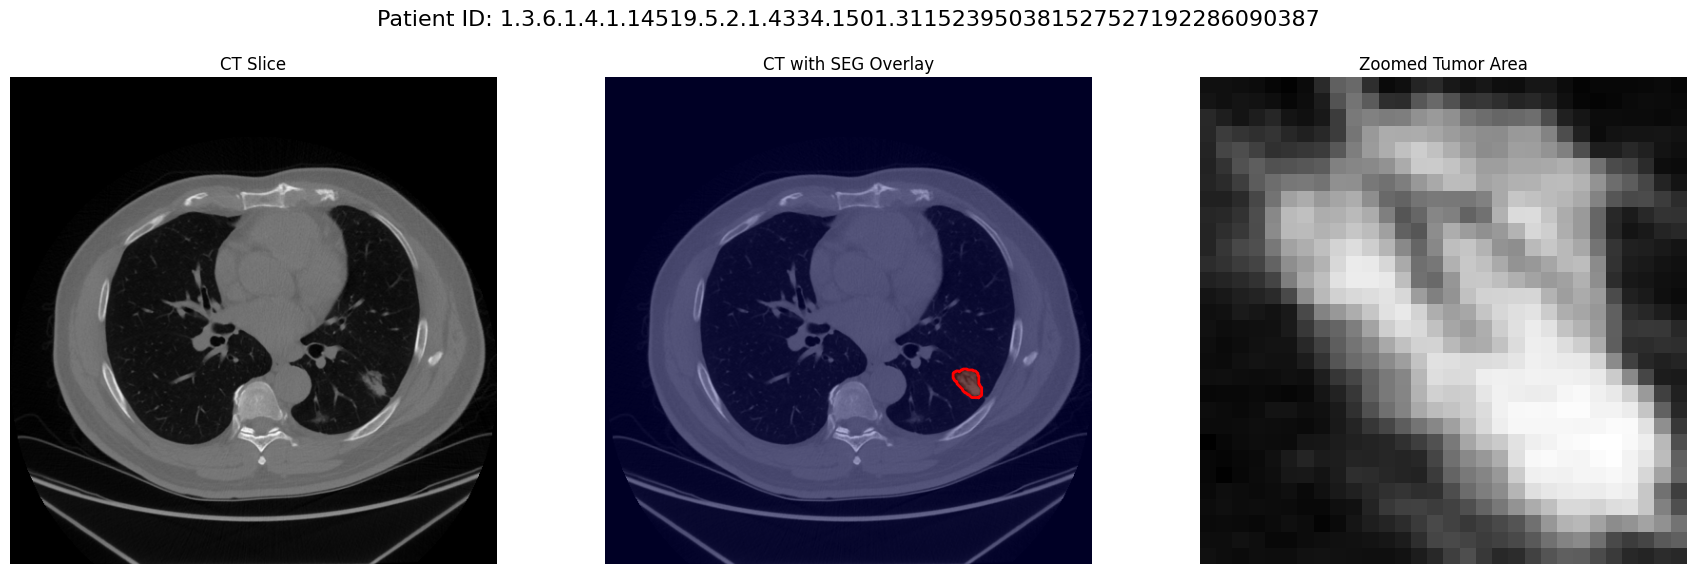

In [42]:
import time

# Load and prepare data
patient_variables, list_key = DICOMPreprocessing.load_and_prepare_data()

# Visualization for all patients
for patient_key in list_key[0:5]:
    try:
        dicom_preprocessor = DICOMPreprocessing(patient_df=patient_variables[patient_key])
        print(f"Visualizing patient {patient_key}")
        dicom_preprocessor.visualize_largest_mask()
    except Exception as e:
        print(f"Error visualizing patient {patient_key}: {e}")
    time.sleep(2)  # Rest for 5 seconds between patients to avoid overloading

In [53]:
import shutil
import os

# Define the directory to clear
working_dir = '/kaggle/working/output_images'

# Check if the directory exists
if os.path.exists(working_dir):
    # Remove all contents in the directory
    shutil.rmtree(working_dir)
    # Recreate the directory
    os.makedirs(working_dir)
    print(f"Cleared and recreated the directory: {working_dir}")
else:
    print(f"Directory {working_dir} does not exist.")


Cleared and recreated the directory: /kaggle/working/output_images


In [54]:
from tqdm import tqdm
import gc

# Iterate through each patient and save tumor areas with progress tracking
for patient_key in tqdm(list_key, desc="Saving tumor areas"):
    # Initialize the DICOMPreprocessing class for the current patient
    dicom_preprocessor = DICOMPreprocessing(patient_df=patient_variables[patient_key])

    # Save the largest tumor areas for the current patient
    dicom_preprocessor.save_all(output_dir=working_dir, image_size=(224, 224))

    # Release memory for the current patient
    del dicom_preprocessor
    gc.collect()

Saving tumor areas:   0%|          | 0/144 [00:00<?, ?it/s]

Saving tumor areas for patient R01-014


Saving tumor areas:   1%|          | 1/144 [00:01<03:28,  1.46s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.203381030227108257540751328879.tiff
Saving tumor areas for patient R01-102
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.303100348519968498568530525363.tiff


Saving tumor areas:   1%|▏         | 2/144 [00:01<01:51,  1.28it/s]

Saving tumor areas for patient R01-031


Saving tumor areas:   2%|▏         | 3/144 [00:03<02:38,  1.12s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.553019895956157318420118637376.tiff
Saving tumor areas for patient R01-107


Saving tumor areas:   3%|▎         | 4/144 [00:03<01:55,  1.22it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.299234974044277500539088418389.tiff
Saving tumor areas for patient R01-058


Saving tumor areas:   3%|▎         | 5/144 [00:04<01:48,  1.28it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.311523950381527527192286090387.tiff
Saving tumor areas for patient R01-105
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.198035184504543515540043212312.tiff


Saving tumor areas:   4%|▍         | 6/144 [00:04<01:20,  1.71it/s]

Saving tumor areas for patient R01-063


Saving tumor areas:   5%|▍         | 7/144 [00:05<01:52,  1.22it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.555621401589041709340992821936.tiff
Saving tumor areas for patient R01-065


Saving tumor areas:   6%|▌         | 8/144 [00:07<02:14,  1.01it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.118835658322930280083721786560.tiff
Saving tumor areas for patient R01-114


Saving tumor areas:   6%|▋         | 9/144 [00:07<01:47,  1.25it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.365334038172941249215997103092.tiff
Saving tumor areas for patient R01-103


Saving tumor areas:   7%|▋         | 10/144 [00:08<01:33,  1.44it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.290645545470202264879884114020.tiff
Saving tumor areas for patient R01-004


Saving tumor areas:   8%|▊         | 11/144 [00:09<02:04,  1.07it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.778951152963012232064284147938.tiff
Saving tumor areas for patient R01-034


Saving tumor areas:   8%|▊         | 12/144 [00:10<02:20,  1.06s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.639526560925927882871050098062.tiff
Saving tumor areas for patient R01-122
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.132851021750996856891725991684.tiff


Saving tumor areas:   9%|▉         | 13/144 [00:11<01:47,  1.22it/s]

Saving tumor areas for patient R01-041


Saving tumor areas:  10%|█         | 15/144 [00:12<01:41,  1.28it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.301933805420543689051609276367.tiff
Saving tumor areas for patient R01-115
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.353433884592155927813694227353.tiff
Saving tumor areas for patient R01-026


Saving tumor areas:  11%|█         | 16/144 [00:13<01:19,  1.62it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.406883927074634881192347324253.tiff
Saving tumor areas for patient R01-090


Saving tumor areas:  12%|█▏        | 17/144 [00:14<01:39,  1.28it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.248406254903351301069927596067.tiff
Saving tumor areas for patient R01-001


Saving tumor areas:  12%|█▎        | 18/144 [00:15<02:03,  1.02it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.194849568492835137645001869117.tiff
Saving tumor areas for patient R01-139


Saving tumor areas:  13%|█▎        | 19/144 [00:16<01:37,  1.28it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.308651797589900694016126718164.tiff
Saving tumor areas for patient R01-078


Saving tumor areas:  14%|█▍        | 20/144 [00:16<01:25,  1.45it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.198265886845268907461609697162.tiff
Saving tumor areas for patient R01-055


Saving tumor areas:  15%|█▍        | 21/144 [00:17<01:45,  1.16it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.261114095052379120210021776760.tiff
Saving tumor areas for patient R01-060


Saving tumor areas:  15%|█▌        | 22/144 [00:18<01:56,  1.05it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.242040564243854333542661068553.tiff
Saving tumor areas for patient R01-126
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.254291117336866468554094575065.tiff


Saving tumor areas:  16%|█▌        | 23/144 [00:19<01:29,  1.35it/s]

Saving tumor areas for patient R01-046


Saving tumor areas:  17%|█▋        | 24/144 [00:20<01:49,  1.10it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.206801900929260562217311560106.tiff
Saving tumor areas for patient R01-146


Saving tumor areas:  17%|█▋        | 25/144 [00:21<01:39,  1.20it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.254560949327495733867144438706.tiff
Saving tumor areas for patient R01-111
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.456311999624576117497655651873.tiff


Saving tumor areas:  18%|█▊        | 26/144 [00:21<01:16,  1.54it/s]

Saving tumor areas for patient R01-094


Saving tumor areas:  19%|█▉        | 27/144 [00:22<01:37,  1.20it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.204029995422721230836785661596.tiff
Saving tumor areas for patient R01-018


Saving tumor areas:  19%|█▉        | 28/144 [00:25<02:56,  1.52s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.118381592990846613081890048750.tiff
Saving tumor areas for patient R01-133


Saving tumor areas:  20%|██        | 29/144 [00:26<02:14,  1.17s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.113093567857368389495247641385.tiff
Saving tumor areas for patient R01-120
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.431417775957188292593442155881.tiff


Saving tumor areas:  21%|██        | 30/144 [00:26<01:41,  1.13it/s]

Saving tumor areas for patient R01-010


Saving tumor areas:  22%|██▏       | 31/144 [00:27<01:59,  1.06s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.311533574623007377892868038852.tiff
Saving tumor areas for patient R01-020


Saving tumor areas:  22%|██▏       | 32/144 [00:28<01:46,  1.05it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.327474389618489768503636232110.tiff
Saving tumor areas for patient R01-080


Saving tumor areas:  23%|██▎       | 33/144 [00:29<01:57,  1.06s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.115590393198684542336235262453.tiff
Saving tumor areas for patient R01-089


Saving tumor areas:  24%|██▎       | 34/144 [00:30<01:38,  1.11it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.407773952400792899763686380255.tiff
Saving tumor areas for patient R01-016


Saving tumor areas:  24%|██▍       | 35/144 [00:31<01:53,  1.04s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.163909679551662375421207740492.tiff
Saving tumor areas for patient R01-074


Saving tumor areas:  25%|██▌       | 36/144 [00:33<02:32,  1.41s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.629221775316771605663856828889.tiff
Saving tumor areas for patient R01-121
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.310879094108601450393769158799.tiff


Saving tumor areas:  26%|██▌       | 37/144 [00:34<01:53,  1.06s/it]

Saving tumor areas for patient R01-091


Saving tumor areas:  26%|██▋       | 38/144 [00:35<02:06,  1.20s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.149583865921102043061980220445.tiff
Saving tumor areas for patient R01-008
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.194234966914983778489661901338.tiff


Saving tumor areas:  27%|██▋       | 39/144 [00:35<01:35,  1.10it/s]

Saving tumor areas for patient R01-022
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.107903178686346114690148976711.tiff


Saving tumor areas:  28%|██▊       | 40/144 [00:36<01:13,  1.41it/s]

Saving tumor areas for patient R01-051


Saving tumor areas:  28%|██▊       | 41/144 [00:37<01:24,  1.21it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.105184935553698488630699282472.tiff
Saving tumor areas for patient R01-119


Saving tumor areas:  29%|██▉       | 42/144 [00:37<01:09,  1.46it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.190483181262071304146134588442.tiff
Saving tumor areas for patient R01-024


Saving tumor areas:  30%|██▉       | 43/144 [00:40<02:06,  1.26s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.239434800461566851862479789896.tiff
Saving tumor areas for patient R01-131
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.995379276753775844765349592955.tiff


Saving tumor areas:  31%|███       | 44/144 [00:40<01:35,  1.05it/s]

Saving tumor areas for patient R01-073


Saving tumor areas:  31%|███▏      | 45/144 [00:41<01:39,  1.01s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.262033880016415405084465873045.tiff
Saving tumor areas for patient R01-002


Saving tumor areas:  32%|███▏      | 46/144 [00:42<01:47,  1.10s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.314873480058883628961162431096.tiff
Saving tumor areas for patient R01-088


Saving tumor areas:  33%|███▎      | 47/144 [00:44<01:55,  1.19s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.326304819110913391852711914100.tiff
Saving tumor areas for patient R01-113


Saving tumor areas:  33%|███▎      | 48/144 [00:44<01:31,  1.05it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.153424202782775072915123179605.tiff
Saving tumor areas for patient R01-124
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.151961065370148535046833652338.tiff


Saving tumor areas:  34%|███▍      | 49/144 [00:45<01:10,  1.35it/s]

Saving tumor areas for patient R01-129


Saving tumor areas:  35%|███▍      | 50/144 [00:45<00:58,  1.62it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.153713896655134488487304641509.tiff
Saving tumor areas for patient R01-015


Saving tumor areas:  35%|███▌      | 51/144 [00:48<02:01,  1.31s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.261249713773269853972467618279.tiff
Saving tumor areas for patient R01-075


Saving tumor areas:  36%|███▌      | 52/144 [00:49<02:11,  1.43s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.207443943407455870340595435813.tiff
Saving tumor areas for patient R01-023


Saving tumor areas:  37%|███▋      | 53/144 [00:50<01:43,  1.14s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.271205290243896201307722464013.tiff
Saving tumor areas for patient R01-137
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.895257848716513258319505812731.tiff


Saving tumor areas:  38%|███▊      | 54/144 [00:50<01:20,  1.12it/s]

Saving tumor areas for patient R01-021


Saving tumor areas:  38%|███▊      | 55/144 [00:52<01:34,  1.06s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.308513455887574850277205266793.tiff
Saving tumor areas for patient R01-142
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.272716599566473061076639049737.tiff


Saving tumor areas:  39%|███▉      | 56/144 [00:52<01:11,  1.24it/s]

Saving tumor areas for patient R01-095


Saving tumor areas:  40%|███▉      | 57/144 [00:53<01:19,  1.10it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.103761676701359868785654810879.tiff
Saving tumor areas for patient R01-068


Saving tumor areas:  41%|████      | 59/144 [00:55<01:09,  1.22it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.209511070481755705659472973690.tiff
Saving tumor areas for patient R01-038
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.256513934865025219917434671237.tiff
Saving tumor areas for patient R01-085


Saving tumor areas:  42%|████▏     | 61/144 [00:56<01:03,  1.30it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.305990201524202424433054613200.tiff
Saving tumor areas for patient R01-132
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.107717629673846674203854064634.tiff
Saving tumor areas for patient R01-125
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.331498434933597324905236191645.tiff


Saving tumor areas:  44%|████▍     | 63/144 [00:57<00:39,  2.07it/s]

Saving tumor areas for patient R01-109
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.997878677073619595638594480652.tiff
Saving tumor areas for patient R01-096


Saving tumor areas:  44%|████▍     | 64/144 [00:58<00:56,  1.41it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.165554541812737547045545126699.tiff
Saving tumor areas for patient R01-127
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.211535690387943604558068192033.tiff


Saving tumor areas:  45%|████▌     | 65/144 [00:58<00:46,  1.70it/s]

Saving tumor areas for patient R01-039


Saving tumor areas:  46%|████▌     | 66/144 [00:59<00:49,  1.58it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.651252356315079754680130788149.tiff
Saving tumor areas for patient R01-106
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.183345524286206632983235013499.tiff


Saving tumor areas:  47%|████▋     | 67/144 [00:59<00:40,  1.91it/s]

Saving tumor areas for patient R01-030


Saving tumor areas:  47%|████▋     | 68/144 [01:01<00:58,  1.29it/s]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.279187641560916567599910172614.tiff
Saving tumor areas for patient R01-011


Saving tumor areas:  48%|████▊     | 69/144 [01:04<01:45,  1.41s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.279727650896486726140209531159.tiff
Saving tumor areas for patient R01-048


Saving tumor areas:  49%|████▊     | 70/144 [01:17<06:15,  5.07s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.323813884667218297386197536506.tiff
Saving tumor areas for patient R01-123


Saving tumor areas:  49%|████▉     | 71/144 [01:18<04:26,  3.66s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.210322332380426613280223716236.tiff
Saving tumor areas for patient R01-006


Saving tumor areas:  50%|█████     | 72/144 [01:27<06:27,  5.38s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.227104262213635435892709835057.tiff
Saving tumor areas for patient R01-086


Saving tumor areas:  51%|█████     | 73/144 [01:31<05:53,  4.98s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.161222917130136044103450487390.tiff
Saving tumor areas for patient R01-013


Saving tumor areas:  51%|█████▏    | 74/144 [01:36<05:37,  4.82s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.210186533596957941690591197860.tiff
Saving tumor areas for patient R01-054


Saving tumor areas:  52%|█████▏    | 75/144 [01:40<05:19,  4.63s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.296024917315107128651362696187.tiff
Saving tumor areas for patient R01-035


Saving tumor areas:  53%|█████▎    | 76/144 [01:44<05:15,  4.64s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.324156147013626649778342052367.tiff
Saving tumor areas for patient R01-047


Saving tumor areas:  53%|█████▎    | 77/144 [01:48<04:52,  4.37s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.203778397654420341159508431102.tiff
Saving tumor areas for patient R01-101


Saving tumor areas:  54%|█████▍    | 78/144 [01:49<03:32,  3.22s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.247287504247665232817081802268.tiff
Saving tumor areas for patient R01-003


Saving tumor areas:  55%|█████▍    | 79/144 [01:53<03:56,  3.63s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.431385591467890620212997685629.tiff
Saving tumor areas for patient R01-116


Saving tumor areas:  56%|█████▌    | 80/144 [01:54<02:49,  2.64s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.660896615593999776058403119424.tiff
Saving tumor areas for patient R01-093


Saving tumor areas:  56%|█████▋    | 81/144 [01:57<03:10,  3.02s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.268122123877676186625117813999.tiff
Saving tumor areas for patient R01-117


Saving tumor areas:  57%|█████▋    | 82/144 [01:58<02:24,  2.33s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.986687663980935732950842735080.tiff
Saving tumor areas for patient R01-050


Saving tumor areas:  58%|█████▊    | 83/144 [02:03<03:07,  3.07s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.144313064024561999551173777925.tiff
Saving tumor areas for patient R01-144


Saving tumor areas:  58%|█████▊    | 84/144 [02:03<02:15,  2.26s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.610404407282508046729615149719.tiff
Saving tumor areas for patient R01-082


Saving tumor areas:  59%|█████▉    | 85/144 [02:07<02:44,  2.79s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.271737642134838209123835605023.tiff
Saving tumor areas for patient R01-043


Saving tumor areas:  60%|█████▉    | 86/144 [02:10<02:30,  2.59s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.238425012509082426843432857838.tiff
Saving tumor areas for patient R01-037


Saving tumor areas:  60%|██████    | 87/144 [02:14<02:59,  3.15s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.120580281843836954931899934243.tiff
Saving tumor areas for patient R01-067


Saving tumor areas:  61%|██████    | 88/144 [02:18<03:11,  3.41s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.117004628736336444539930827771.tiff
Saving tumor areas for patient R01-145


Saving tumor areas:  62%|██████▏   | 89/144 [02:19<02:24,  2.63s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.275624415262168281710581152122.tiff
Saving tumor areas for patient R01-052


Saving tumor areas:  62%|██████▎   | 90/144 [02:21<02:18,  2.57s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.124196818148112799080725609337.tiff
Saving tumor areas for patient R01-077


Saving tumor areas:  63%|██████▎   | 91/144 [02:25<02:33,  2.89s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.816508815366044227444164151588.tiff
Saving tumor areas for patient R01-136
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.253499144658439194935588820179.tiff


Saving tumor areas:  64%|██████▍   | 92/144 [02:25<01:49,  2.11s/it]

Saving tumor areas for patient R01-069


Saving tumor areas:  65%|██████▍   | 93/144 [02:29<02:20,  2.75s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.312463295148507978259306983627.tiff
Saving tumor areas for patient R01-033


Saving tumor areas:  65%|██████▌   | 94/144 [02:34<02:45,  3.32s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.331151771838549568969459981397.tiff
Saving tumor areas for patient R01-141


Saving tumor areas:  66%|██████▌   | 95/144 [02:35<02:00,  2.47s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.192055143347551166084892827910.tiff
Saving tumor areas for patient R01-012


Saving tumor areas:  67%|██████▋   | 96/144 [02:40<02:47,  3.50s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.296302715635385591412290568238.tiff
Saving tumor areas for patient R01-070


Saving tumor areas:  67%|██████▋   | 97/144 [02:44<02:51,  3.64s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.199785130945170463543472115965.tiff
Saving tumor areas for patient R01-118


Saving tumor areas:  68%|██████▊   | 98/144 [02:45<02:05,  2.73s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.335797460926179994099221406115.tiff
Saving tumor areas for patient R01-099


Saving tumor areas:  69%|██████▉   | 99/144 [02:46<01:38,  2.19s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.171030500113786957723142909947.tiff
Saving tumor areas for patient R01-064


Saving tumor areas:  69%|██████▉   | 100/144 [02:50<01:56,  2.65s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.307275102678463145156203830522.tiff
Saving tumor areas for patient R01-045


Saving tumor areas:  70%|███████   | 101/144 [02:54<02:19,  3.23s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.255925717448493719149143025097.tiff
Saving tumor areas for patient R01-017


Saving tumor areas:  71%|███████   | 102/144 [02:58<02:19,  3.32s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.116470993404525012513158034797.tiff
Saving tumor areas for patient R01-029


Saving tumor areas:  72%|███████▏  | 103/144 [03:02<02:25,  3.55s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.203635672592149412227415389883.tiff
Saving tumor areas for patient R01-140


Saving tumor areas:  72%|███████▏  | 104/144 [03:02<01:44,  2.60s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.268844798237671685540367284831.tiff
Saving tumor areas for patient R01-100


Saving tumor areas:  73%|███████▎  | 105/144 [03:03<01:18,  2.01s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.286601297126453465879824328207.tiff
Saving tumor areas for patient R01-025


Saving tumor areas:  74%|███████▎  | 106/144 [03:12<02:34,  4.06s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.299517982591339547334670730585.tiff
Saving tumor areas for patient R01-079


Saving tumor areas:  74%|███████▍  | 107/144 [03:14<02:07,  3.45s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.307656421227591022298133385915.tiff
Saving tumor areas for patient R01-083


Saving tumor areas:  75%|███████▌  | 108/144 [03:16<01:52,  3.14s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.696149824662228954005362078362.tiff
Saving tumor areas for patient R01-138


Saving tumor areas:  76%|███████▌  | 109/144 [03:17<01:21,  2.33s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.861261956852330424243534438431.tiff
Saving tumor areas for patient R01-084


Saving tumor areas:  76%|███████▋  | 110/144 [03:21<01:42,  3.00s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.334955403098633167411200408058.tiff
Saving tumor areas for patient R01-108


Saving tumor areas:  77%|███████▋  | 111/144 [03:22<01:13,  2.21s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.331864380691466148389924862210.tiff
Saving tumor areas for patient R01-062


Saving tumor areas:  78%|███████▊  | 112/144 [03:25<01:24,  2.65s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.152840362182210510092793991633.tiff
Saving tumor areas for patient R01-128


Saving tumor areas:  78%|███████▊  | 113/144 [03:26<01:02,  2.03s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.275453297667129803503963496373.tiff
Saving tumor areas for patient R01-049


Saving tumor areas:  79%|███████▉  | 114/144 [03:31<01:30,  3.03s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.183357099857017676503610559870.tiff
Saving tumor areas for patient R01-053


Saving tumor areas:  80%|███████▉  | 115/144 [03:33<01:20,  2.77s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.307181903788310291391890331288.tiff
Saving tumor areas for patient R01-110


Saving tumor areas:  81%|████████  | 116/144 [03:34<00:59,  2.11s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.309755826175620154393954985992.tiff
Saving tumor areas for patient R01-059


Saving tumor areas:  81%|████████▏ | 117/144 [03:38<01:12,  2.69s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.988235729521350583852240412852.tiff
Saving tumor areas for patient R01-042


Saving tumor areas:  82%|████████▏ | 118/144 [03:42<01:20,  3.09s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.309128270554791340619892776896.tiff
Saving tumor areas for patient R01-019


Saving tumor areas:  83%|████████▎ | 119/144 [03:47<01:28,  3.52s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.308673016574334001275060228587.tiff
Saving tumor areas for patient R01-032


Saving tumor areas:  83%|████████▎ | 120/144 [03:51<01:32,  3.86s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.272425482905277815619188134939.tiff
Saving tumor areas for patient R01-007


Saving tumor areas:  84%|████████▍ | 121/144 [03:56<01:34,  4.11s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.965353665272099976571829330165.tiff
Saving tumor areas for patient R01-036


Saving tumor areas:  85%|████████▍ | 122/144 [04:01<01:39,  4.51s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.228980550020809104027107682439.tiff
Saving tumor areas for patient R01-072


Saving tumor areas:  85%|████████▌ | 123/144 [04:06<01:36,  4.59s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.140223279372566271560464831821.tiff
Saving tumor areas for patient R01-066


Saving tumor areas:  86%|████████▌ | 124/144 [04:08<01:16,  3.84s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.144425081742517191847604606512.tiff
Saving tumor areas for patient R01-044


Saving tumor areas:  87%|████████▋ | 125/144 [04:10<01:03,  3.35s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.130428586467280386032069092384.tiff
Saving tumor areas for patient R01-135


Saving tumor areas:  88%|████████▊ | 126/144 [04:11<00:46,  2.60s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.246834405982941702724047970820.tiff
Saving tumor areas for patient R01-027


Saving tumor areas:  88%|████████▊ | 127/144 [04:14<00:44,  2.62s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.559078504766516849307983964467.tiff
Saving tumor areas for patient R01-104
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.227828658416444165019136725393.tiff


Saving tumor areas:  89%|████████▉ | 128/144 [04:14<00:30,  1.91s/it]

Saving tumor areas for patient R01-071


Saving tumor areas:  90%|████████▉ | 129/144 [04:16<00:28,  1.87s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.616661061043176947499161423400.tiff
Saving tumor areas for patient R01-130
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.534350616034448863720055317589.tiff


Saving tumor areas:  90%|█████████ | 130/144 [04:16<00:19,  1.39s/it]

Saving tumor areas for patient R01-057


Saving tumor areas:  91%|█████████ | 131/144 [04:18<00:19,  1.48s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.226724630198079913945931168022.tiff
Saving tumor areas for patient R01-134
Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.115868185078472232968938556560.tiff


Saving tumor areas:  92%|█████████▏| 132/144 [04:18<00:13,  1.11s/it]

Saving tumor areas for patient R01-087


Saving tumor areas:  92%|█████████▏| 133/144 [04:21<00:16,  1.50s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.228829754622449893536912618768.tiff
Saving tumor areas for patient R01-098


Saving tumor areas:  93%|█████████▎| 134/144 [04:21<00:11,  1.20s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.102878477945054489386769969883.tiff
Saving tumor areas for patient R01-081


Saving tumor areas:  94%|█████████▍| 135/144 [04:28<00:26,  2.93s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.210583834547833020270614633968.tiff
Saving tumor areas for patient R01-005


Saving tumor areas:  94%|█████████▍| 136/144 [04:33<00:29,  3.69s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.296312982213702857488999502080.tiff
Saving tumor areas for patient R01-112


Saving tumor areas:  95%|█████████▌| 137/144 [04:36<00:22,  3.23s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.458802680785294969764479332389.tiff
Saving tumor areas for patient R01-076


Saving tumor areas:  96%|█████████▌| 138/144 [04:37<00:15,  2.66s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.685339142284878388826567597209.tiff
Saving tumor areas for patient R01-040


Saving tumor areas:  97%|█████████▋| 139/144 [04:40<00:13,  2.80s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.496590204166540955441709399863.tiff
Saving tumor areas for patient R01-097


Saving tumor areas:  97%|█████████▋| 140/144 [04:42<00:09,  2.42s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.114261476622627046716051771833.tiff
Saving tumor areas for patient R01-056


Saving tumor areas:  98%|█████████▊| 141/144 [04:43<00:06,  2.18s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.142669263063195426279909288511.tiff
Saving tumor areas for patient R01-061


Saving tumor areas:  99%|█████████▊| 142/144 [04:44<00:03,  1.77s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.211346530152612465390039965868.tiff
Saving tumor areas for patient R01-092


Saving tumor areas:  99%|█████████▉| 143/144 [04:46<00:01,  1.73s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.713657874760187739746944243855.tiff
Saving tumor areas for patient R01-028


Saving tumor areas: 100%|██████████| 144/144 [04:47<00:00,  2.00s/it]

Saved tumor area image to output_images/1.3.6.1.4.1.14519.5.2.1.4334.1501.235963655862954404967259088811.tiff


In [55]:
import zipfile
import os

def zip_folder(folder_path, zip_file_path):
    """
    Compress a folder into a zip file.
    
    Parameters:
    folder_path (str): Path to the folder to be zipped.
    zip_file_path (str): Path where the zip file will be saved.
    """
    with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through the folder
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                # Create relative path for the file
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                # Add file to the zip
                zipf.write(file_path, arcname)

# Define paths
output_folder = '/kaggle/working/output_images'
zip_file = '/kaggle/working/ROI.zip'

# Zip the output folder
zip_folder(output_folder, zip_file)

print(f"Folder '{output_folder}' has been compressed into '{zip_file}'.")

Folder '/kaggle/working/output_images' has been compressed into '/kaggle/working/ROI.zip'.


In [62]:
DICOMPreprocessing.save_data("/kaggle/working/recurrence.csv")

/tmp/ipykernel_36/1468111028.py:43: DtypeWarning: Columns (5,9,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df_label = pd.read_csv("/kaggle/input/nsclc-radiogenomics-6-1-21-version-4/processed_df.csv")


Data saved to /kaggle/working/recurrence.csv
